In [1]:
import pandas as pd

from modules.plotting_scripts import plot_surprisals, get_avg_df, plot_avg_pos_neg

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def trend_categories(df, first_step=True):

    def determine_trend(values):
        X = np.arange(len(values)).reshape(-1, 1)
        model = LinearRegression().fit(X, values)
        slope = model.coef_[0]
        return 'Increasing' if slope > 0 else 'Decreasing'

    categories = defaultdict(lambda: [0, []])

    if not first_step:
        df = df[df['Steps'] != 0]
        
    grouped = df.groupby('Token')
    
    for word, word_data in grouped:
        surprisal_values = word_data['MeanSurprisal'].values.reshape(-1, 1)
        antisurprisal_values = word_data['MeanNegSurprisal'].values.reshape(-1, 1)
        
        surprisal_trend = determine_trend(surprisal_values)
        antisurprisal_trend = determine_trend(antisurprisal_values)
        
        key = f"{surprisal_trend}-{antisurprisal_trend}"
        categories[key][0] += 1
        categories[key][1].append(word)
    
    return categories


In [3]:
path = '../results/indiv_surprisals_full.tsv'
indiv_surprisals = pd.read_csv(path, delimiter='\t')

indiv_surprisals = indiv_surprisals.assign(
    MeanSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['Surprisal'].transform('mean'),
    MeanNegSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['NegSurprisal'].transform('mean')
)

indiv_surprisals

,Steps,Token,Context,Surprisal,NegSurprisal,MeanSurprisal,MeanNegSurprisal
0,0,a,"[101, 2728, 8945, 11314, 2121, 2003, 2019, 239...",14.215013,14.323027,14.225594,14.234500
1,0,a,"[101, 2023, 2001, 2628, 2011, 103, 4626, 2535,...",13.940619,14.543520,14.225594,14.234500
2,0,a,"[101, 1999, 2432, 8945, 11314, 2121, 5565, 103...",14.588675,14.688922,14.225594,14.234500
3,0,a,"[101, 2002, 2001, 2856, 2011, 2198, 14381, 199...",13.849343,14.169744,14.225594,14.234500
4,0,a,"[101, 2002, 2596, 2006, 1037, 2294, 2792, 1997...",13.696613,13.988950,14.225594,14.234500
...,...,...,...,...,...,...,...
3064889,2000000,zoom,"[101, 2002, 2915, 1996, 2878, 2143, 2012, 1996...",1.668615,7.264644,2.738938,13.967112
3064890,2000000,zu,"[101, 1996, 2047, 2142, 2163, 3212, 103, 2213,...",0.002864,29.544127,2.828315,27.215050
3064891,2000000,zu,"[101, 4415, 11383, 4874, 22486, 1005, 1055, 64...",0.000113,28.785532,2.828315,27.215050
3064892,2000000,zu,"[101, 2002, 2036, 2354, 1010, 2030, 2018, 2081...",6.268449,24.433737,2.828315,27.215050


In [4]:
example_counts = indiv_surprisals[indiv_surprisals.Steps == 0].Token.value_counts()
print(f"Maximum number of examples: {example_counts.max()}")
print(f"Minimum number of examples: {example_counts.min()}")
print(f"Average number of examples: {example_counts.mean()}")

Maximum number of examples: 512
Minimum number of examples: 1
Average number of examples: 11.641991628111919


In [5]:
example_counts = example_counts.reset_index().rename(columns={'count': 'Frequency'})

Plot saved to ../corpus_surprisal.pdf


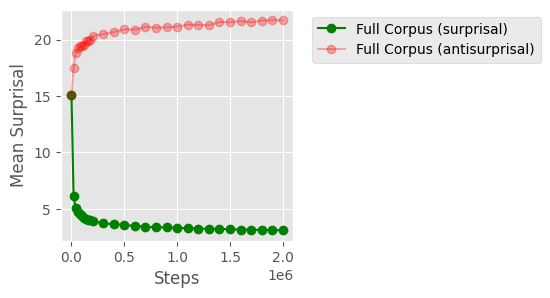

In [6]:
positives = get_avg_df([indiv_surprisals], column='MeanSurprisal')
negatives = get_avg_df([indiv_surprisals], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives, save_as='../corpus_surprisal.pdf')

In [7]:
surprisals = indiv_surprisals[['Steps', 'Token', 'MeanSurprisal', 'MeanNegSurprisal']].drop_duplicates().reset_index(drop=True)
surprisals = surprisals.merge(example_counts)
surprisals

,Steps,Token,MeanSurprisal,MeanNegSurprisal,Frequency
0,0,a,14.225594,14.234500,512
1,0,aa,15.597247,15.751283,16
2,0,abandon,15.298998,15.042455,1
3,0,abandoned,14.781739,14.788133,26
4,0,abandoning,14.522403,14.334804,1
...,...,...,...,...,...
263257,2000000,zone,4.706525,22.451706,20
263258,2000000,zones,2.175875,23.845009,5
263259,2000000,zoo,5.894639,15.055669,2
263260,2000000,zoom,2.738938,13.967112,2


In [8]:
categories = trend_categories(surprisals)
categories_df = pd.DataFrame(categories, index=['count', 'words']).transpose()
categories_df

,count,words
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando..."
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations..."
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci..."
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ..."


In [9]:
infreq_tokens = surprisals[surprisals.Frequency <= 10].Token.unique()
print(f"Number of infrequent (frequency ≤ 10) tokens in the word bank: {len(infreq_tokens)}")

Number of infrequent (frequency ≤ 10) tokens in the word bank: 7231


In [10]:
# proportion of the category covered by infrequent tokens
categories_df['cat_coverage'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(x), 2))

# proportion (distribution) of infrequent tokens in each category
categories_df['infreq_prop'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(infreq_tokens), 2))

categories_df

,count,words,cat_coverage,infreq_prop
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",0.78,0.89
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",1.00,0.07
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",0.99,0.03
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",1.00,0.01


In [11]:
def calculate_stats(word_list, word_freqs_df):
    frequencies = word_freqs_df[word_freqs_df['Token'].isin(word_list)]['Frequency']
    return pd.Series([int(frequencies.min()), int(frequencies.max()), int(frequencies.median()), round(frequencies.mean())],
                     index=['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq'])

categories_df[['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq']] = categories_df['words'].apply(
    lambda words: calculate_stats(words, surprisals)
)

categories_df = categories_df.reset_index().rename(columns={'index': 'trend_category'})
# categories_df.to_csv('../results/surp_antisurp_trends.csv', index=None)
categories_df

,trend_category,count,words,cat_coverage,infreq_prop,min_freq,max_freq,median_freq,rounded_mean_freq
0,Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",0.78,0.89,1,512,4,13
1,Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",1.00,0.07,1,10,1,2
2,Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",0.99,0.03,1,18,1,2
3,Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",1.00,0.01,1,2,1,1


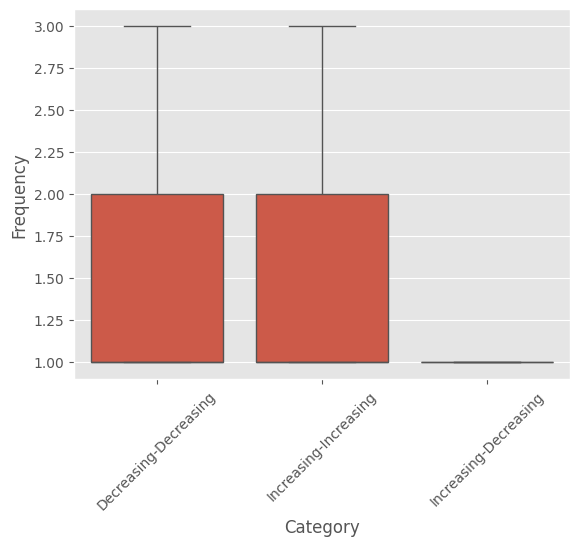

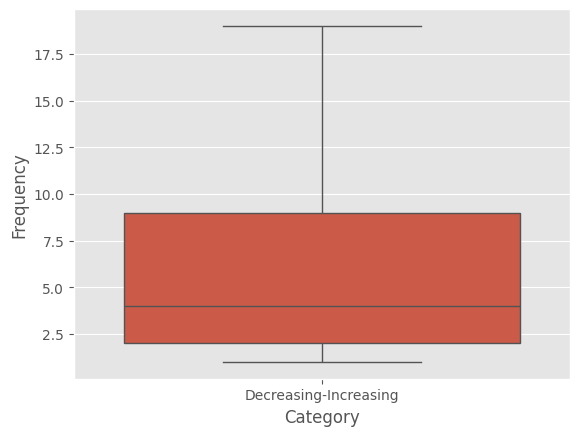

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

expanded_df = categories_df.explode('words')

merged_df = pd.merge(expanded_df, surprisals, left_on='words', right_on='Token')

sns.boxplot(x='trend_category', y='Frequency', data=merged_df[merged_df.trend_category != 'Decreasing-Increasing'], showfliers=False)

# plt.title('Box Plot of Word Frequencies by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.savefig('../box_minority_trends.pdf', format='pdf', bbox_inches='tight')
plt.show()

sns.boxplot(x='trend_category', y='Frequency', data=merged_df[merged_df.trend_category == 'Decreasing-Increasing'], showfliers=False)
plt.xlabel('Category')
plt.savefig('../box_majority_trend.pdf', format='pdf', bbox_inches='tight')
plt.show()

Figure saved to ../trend_neg_corr.pdf


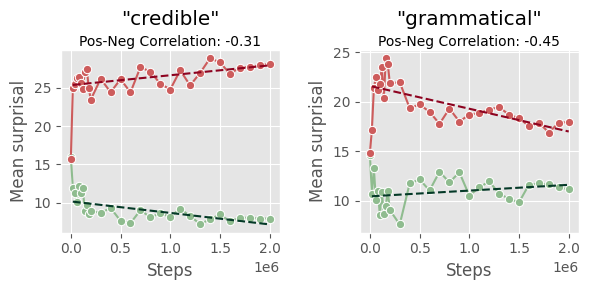

Figure saved to ../trend_pos_corr.pdf


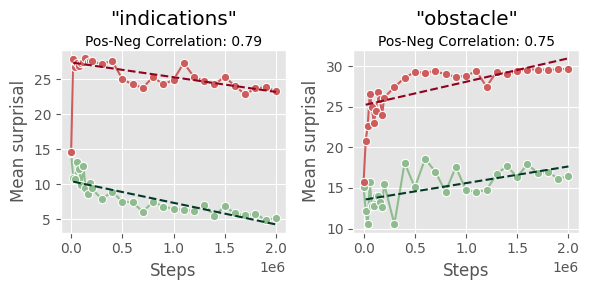

In [4]:
# Decreasing-Increasing: 'flesh'/'banned'/'regain'/'heating', 
# Increasing-Decreasing: 'comical'/'jewellery'/'outdoor'/'grammatical'
# Decreasing-Decreasing: 'creature'/'indications'
# Increasing-Increasing: 'neighbourhoods'/'silly'/'brow'/'predictions'/'obstacle'

words = ['credible', 'grammatical']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False, legend=False, save_as='../trend_neg_corr.pdf') 
words = ['indications', 'obstacle']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False, legend=False, save_as='../trend_pos_corr.pdf')